In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path
import argparse
import logging

from common.paths import CONFIG_FILE, OUTPUT_DIR

def load_config():
    """Load configuration file."""
    if not CONFIG_FILE.exists():
        raise FileNotFoundError(f"Config file not found at {CONFIG_FILE}")
    with open(CONFIG_FILE, 'r') as f:
        return json.load(f)

config = load_config()

def get_active_strategies(account: str):
    """Return list of active strategy names for the specified account."""
    active_strategies = [
        strat_name for strat_name, strat_config in config.get('strategy', {}).items()
        if strat_config.get('active', False) and
        strat_config.get('account_trade', '') == account and
        strat_config.get('exchange_trade', 'bitget') == 'bitget'
    ]
    print(f"Active strategies for account {account}: {active_strategies}")
    return active_strategies

def plot_metrics(selection: str, show_strategies: bool = False):
    """
    Plot portfolio metrics over time for a strategy or account.
    For strategies (active only):
      - portfolio_return_pct, portfolio_realized_pnl, portfolio_unrealized_pnl
    For accounts:
      - portfolio_return_pct, portfolio_total_pnl, portfolio_realized_pnl, portfolio_unrealized_pnl
      - Optionally overlay active strategy-level realized and unrealized PnL
    """
    # Get active strategies
    active_strategies = get_active_strategies(selection)
    accounts = list(config.get('allocations', {}).get('bitget', {}).keys())
    is_strategy = selection in active_strategies
    is_account = selection in accounts
    
    # Validate selection
    if not (is_strategy or is_account):
        if selection in config.get('strategy', {}):
            print(f"'{selection}' is an inactive strategy. Active strategies: {active_strategies}")
        else:
            print(f"'{selection}' is neither a valid active strategy nor an account.")
        return
    
    # Helper to load timeline data
    def load_timeline(entity: str, is_acc: bool = False) -> dict:
        path = OUTPUT_DIR / (f"pnl_timeline_account_{entity}.json" if is_acc else f"pnl_timeline_{entity}.json")
        if not path.exists():
            print(f"{path} not found")
            return {}
        try:
            with open(path, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            return {}
    
    # Collect data
    timeline_data = {}
    if is_strategy:
        timeline_data[selection] = load_timeline(selection, False)
    else:
        timeline_data[selection] = load_timeline(selection, True)
        if show_strategies:
            # Load active strategies for this account
            account_strategies = config.get('allocations', {}).get('bitget', {}).get(selection, {}).get('strategies', active_strategies)
            account_strategies = [s for s in account_strategies if s in active_strategies]
            print(f"Overlaying active strategies for account {selection}: {account_strategies}")
            for strat in account_strategies:
                timeline_data[strat] = load_timeline(strat, False)
    
    if not timeline_data:
        print(f"No data available for {selection}")
        return
    
    # Create subplots
    n_plots = 3 if is_strategy else 4
    fig, axs = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots), sharex=True)
    axs = [axs] if n_plots == 1 else axs  # Handle single subplot case
    
    # Plot metrics
    plot_idx = 0
    
    # 1) Portfolio Return %
    for label, series in timeline_data.items():
        timestamps = sorted(series.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
        ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in timestamps]
        vals = [series[ts].get('portfolio_return_pct', None) for ts in timestamps]
        vals = [v * 100 if v is not None else None for v in vals]  # Convert to percentage
        linestyle = '-' if label == selection or not show_strategies else '--'
        label_suffix = ' (Account)' if is_account and label == selection and show_strategies else '(Strategy)' if is_account and label != selection else ''
        axs[plot_idx].plot(ts_dt, vals, linestyle=linestyle, label=f"{label}{label_suffix}")
    axs[plot_idx].set_title('Portfolio Return')
    axs[plot_idx].set_ylabel('Return (%)')
    axs[plot_idx].grid(True)
    axs[plot_idx].legend()
    plot_idx += 1
    
    # 2) Portfolio Total PnL (Account only)
    if is_account:
        for label, series in timeline_data.items():
            if label != selection:
                continue
            timestamps = sorted(series.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
            ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in timestamps]
            vals = []
            for ts in timestamps:
                data = series[ts]
                realized = data.get('portfolio_realized_pnl', 0) or 0
                unrealized = data.get('portfolio_unrealized_pnl', 0) or 0
                total_pnl = realized + unrealized
                vals.append(total_pnl)
            axs[plot_idx].plot(ts_dt, vals, label=f"{label} (Account)")
        axs[plot_idx].set_title('Portfolio Total PnL')
        axs[plot_idx].set_ylabel('PnL (USD)')
        axs[plot_idx].grid(True)
        axs[plot_idx].legend()
        plot_idx += 1
    
    # 3) Portfolio Realized PnL
    for label, series in timeline_data.items():
        if is_account and label != selection and not show_strategies:
            continue
        timestamps = sorted(series.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
        ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in timestamps]
        vals = [series[ts].get('portfolio_realized_pnl', None) for ts in timestamps]
        linestyle = '-' if label == selection or is_strategy else '--'
        label_suffix = ' (Strategy)' if is_account and label != selection else ''
        axs[plot_idx].plot(ts_dt, vals, linestyle=linestyle, label=f"{label}{label_suffix}")
    axs[plot_idx].set_title('Portfolio Realized PnL')
    axs[plot_idx].set_ylabel('PnL (USD)')
    axs[plot_idx].grid(True)
    axs[plot_idx].legend()
    plot_idx += 1
    
    # 4) Portfolio Unrealized PnL
    for label, series in timeline_data.items():
        if is_account and label != selection and not show_strategies:
            continue
        timestamps = sorted(series.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
        ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in timestamps]
        vals = [series[ts].get('portfolio_unrealized_pnl', None) for ts in timestamps]
        linestyle = '-' if label == selection or is_strategy else '--'
        label_suffix = ' (Strategy)' if is_account and label != selection else ''
        axs[plot_idx].plot(ts_dt, vals, linestyle=linestyle, label=f"{label}{label_suffix}")
    axs[plot_idx].set_title('Portfolio Unrealized PnL')
    axs[plot_idx].set_ylabel('PnL (USD)')
    axs[plot_idx].grid(True)
    axs[plot_idx].legend()
    
    # X-axis formatting
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Timestamp')
    plt.tight_layout()
    
    plt.show()

def load_timeline(entity: str, is_account: bool = False, is_real: bool = False) -> dict:
    """Load timeline data for a strategy or account."""
    prefix = "bot_real_pnl" if is_real else "pnl_timeline"
    suffix = f"account_{entity}" if is_account else entity
    path = OUTPUT_DIR / f"{prefix}_{suffix}.json"
    if not path.exists():
        return {}
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except Exception as e:
        return {}

def plot_real_vs_theo_pnl(account: str):
    """Plot real vs theoretical USD PnL for the account and each active strategy."""
    # Get active strategies for the account
    strategies = get_active_strategies(account)
    if not strategies:
        return

    # Load account timelines
    real_account_timeline = load_timeline(account, is_account=True, is_real=True)
    theo_account_timeline = load_timeline(account, is_account=True, is_real=False)
    if not real_account_timeline or not theo_account_timeline:
        return

    # Plot for account
    fig, ax = plt.subplots(figsize=(12, 6))
    # Use separate timestamps for real and theoretical data
    real_timestamps = sorted(real_account_timeline.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
    theo_timestamps = sorted(theo_account_timeline.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
    real_ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in real_timestamps]
    theo_ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in theo_timestamps]

    # Real USD PnL
    real_vals = [real_account_timeline[ts].get('cumulative_usd_pnl', 0) for ts in real_timestamps]
    ax.plot(real_ts_dt, real_vals, label='Real USD PnL', color='blue')

    # Theoretical USD PnL
    theo_vals = [theo_account_timeline[ts].get('portfolio_realized_pnl', 0) for ts in theo_timestamps]
    ax.plot(theo_ts_dt, theo_vals, label='Theoretical USD PnL', color='orange', linestyle='--')

    ax.set_title(f'Real vs Theoretical USD PnL for Account {account}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('PnL (USD)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.grid(True)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot for each strategy
    for strategy in strategies:
        real_timeline = load_timeline(strategy, is_account=False, is_real=True)
        theo_timeline = load_timeline(strategy, is_account=False, is_real=False)
        if not real_timeline or not theo_timeline:
            continue

        fig, ax = plt.subplots(figsize=(12, 6))
        # Use separate timestamps for real and theoretical data
        real_timestamps = sorted(real_timeline.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
        theo_timestamps = sorted(theo_timeline.keys(), key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
        real_ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in real_timestamps]
        theo_ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in theo_timestamps]

        # Real USD PnL
        real_vals = [real_timeline[ts].get('cumulative_usd_pnl', 0) for ts in real_timestamps]
        ax.plot(real_ts_dt, real_vals, label='Real USD PnL', color='blue')

        # Theoretical USD PnL
        theo_vals = [theo_timeline[ts].get('portfolio_realized_pnl', 0) for ts in theo_timestamps]
        ax.plot(theo_ts_dt, theo_vals, label='Theoretical realized USD PnL', color='orange', linestyle='--')

        ax.set_title(f'Real vs Theoretical USD PnL for Strategy {strategy}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('PnL (USD)')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
        ax.grid(True)
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Active strategies for account 2: ['basket1', 'basket1b', 'basket2', 'basket2b']


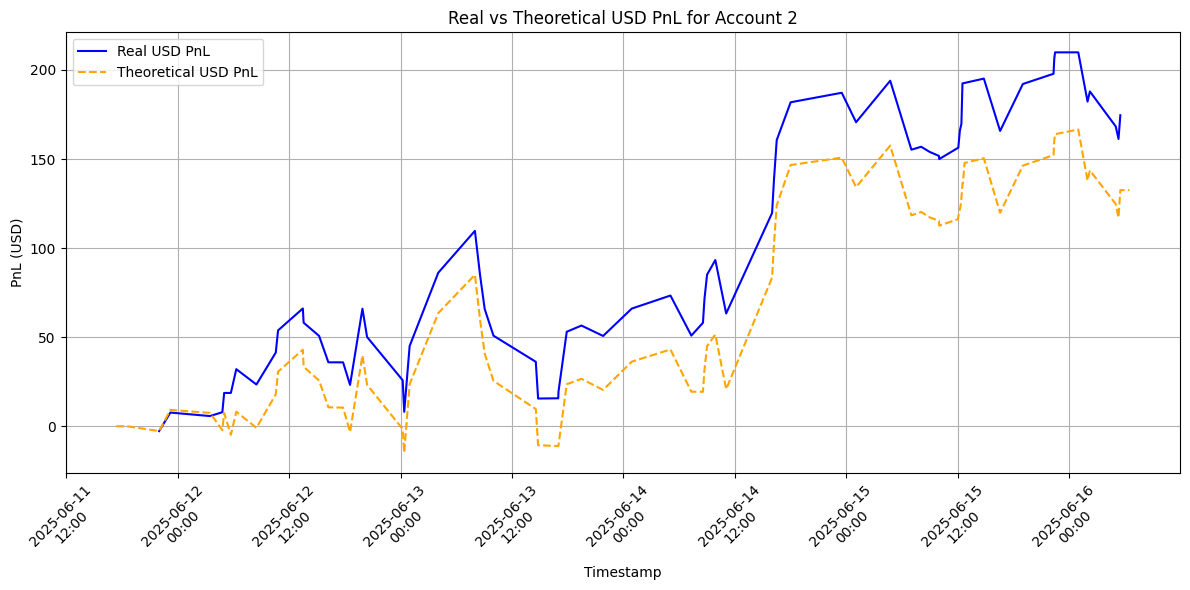

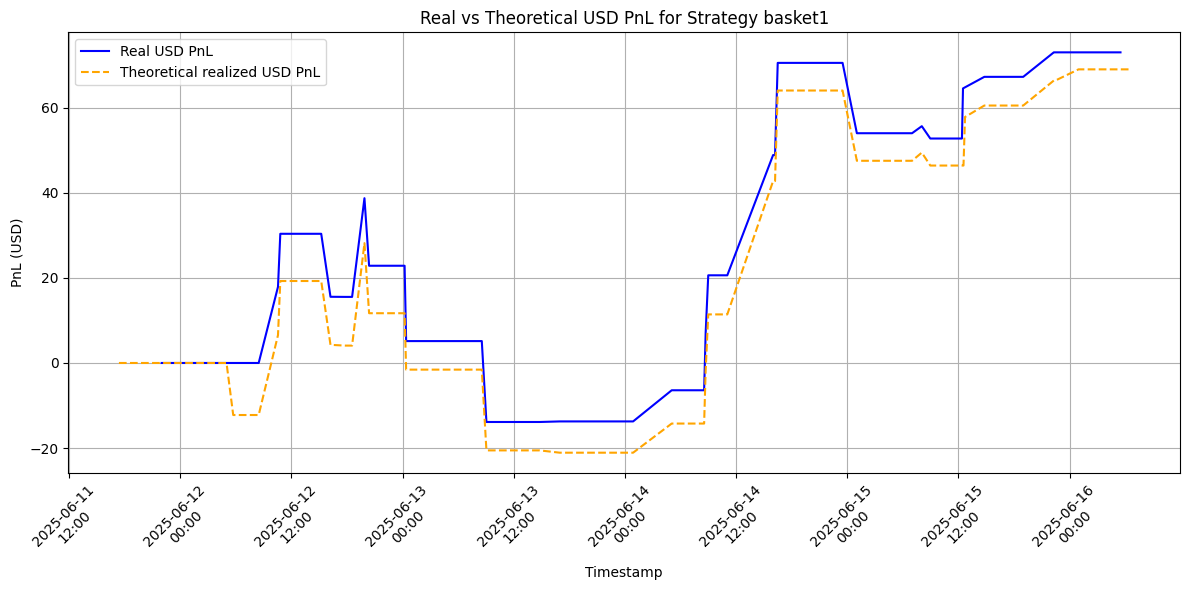

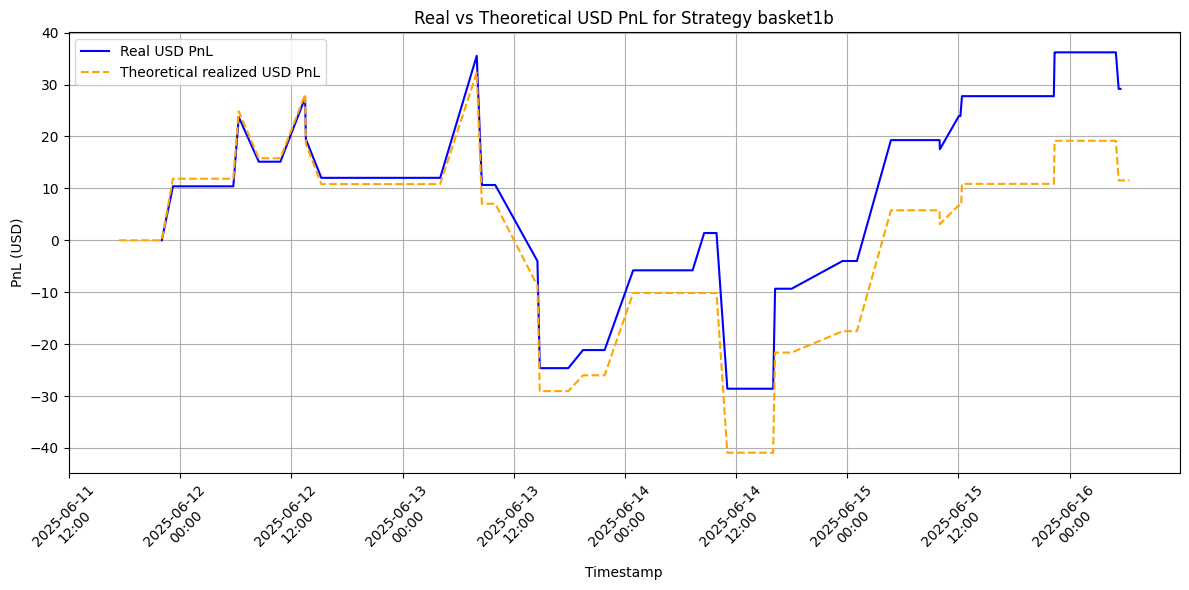

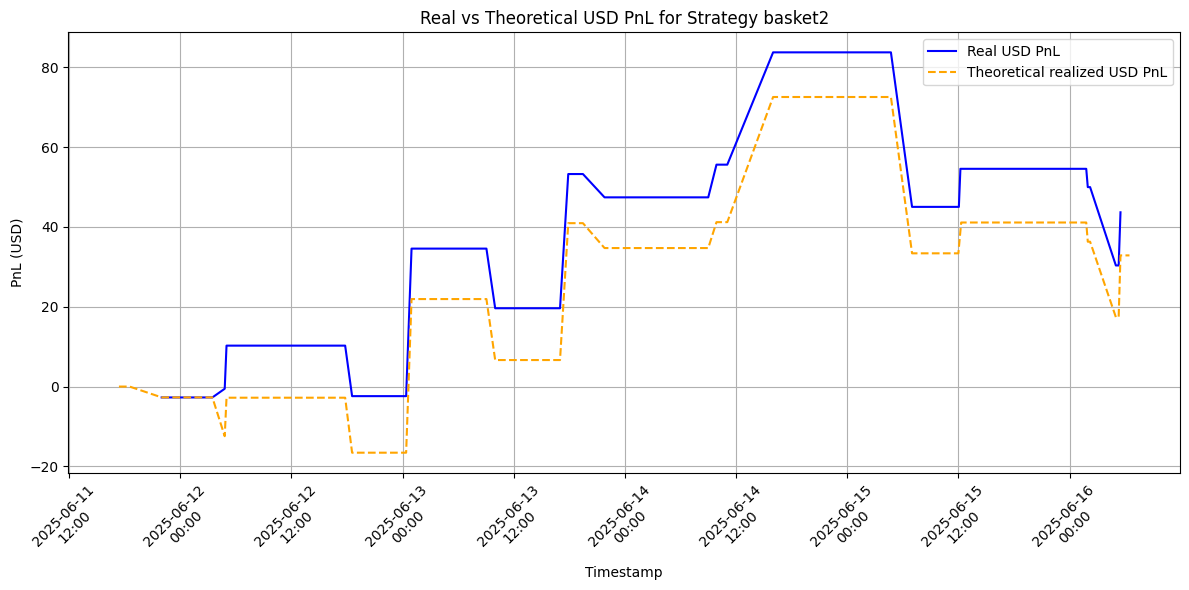

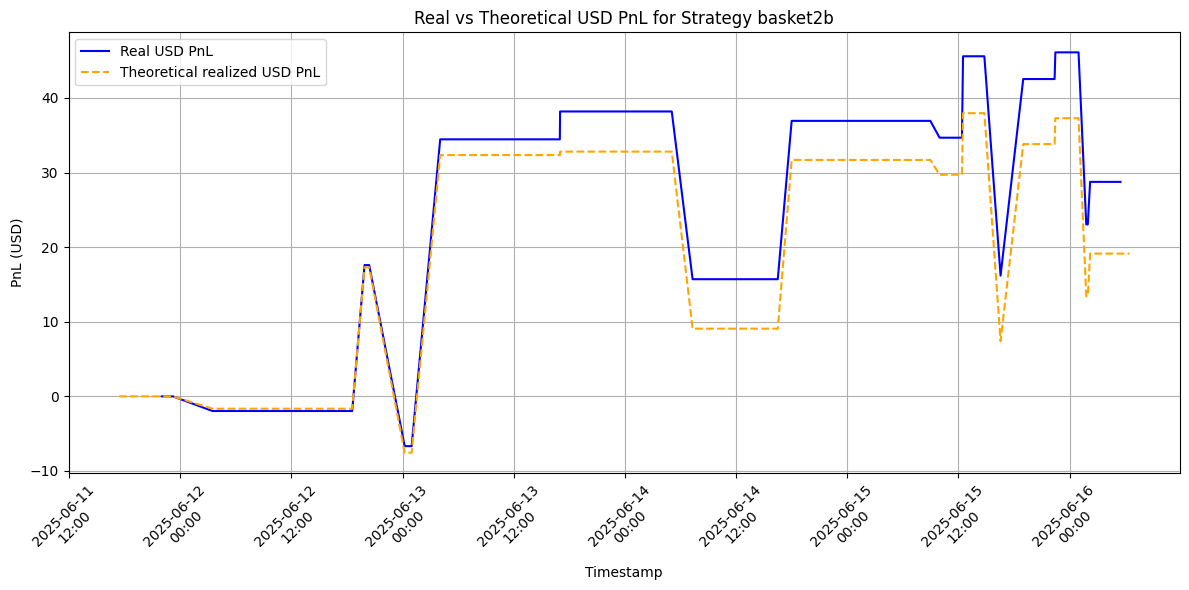

In [2]:
# Example usage
plot_real_vs_theo_pnl('2')


Active strategies for account 2: ['basket1', 'basket1b', 'basket2', 'basket2b']
Overlaying active strategies for account 2: ['basket1', 'basket1b', 'basket2', 'basket2b']


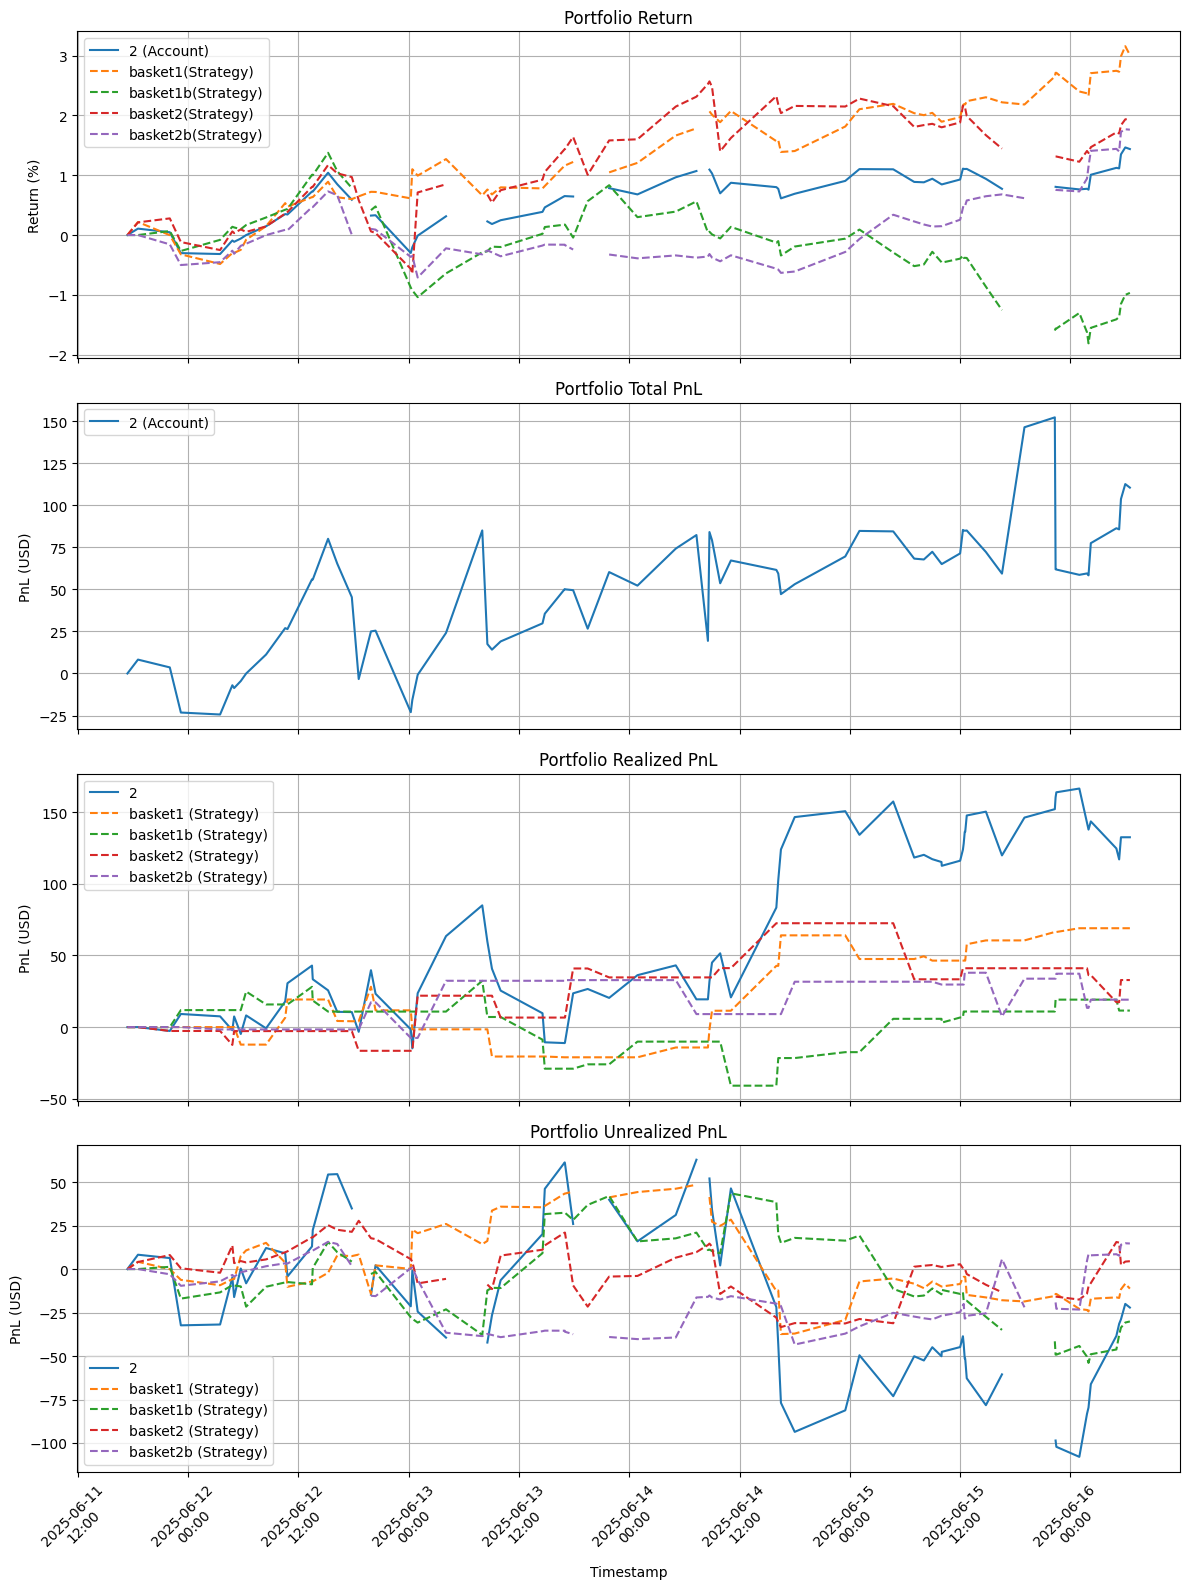

In [3]:
plot_metrics('2', show_strategies=True)  # Example for account with strategies